# Step 4. Trade-Off Analysis
## *Group 11. Multi-Scenario MORDM*

## Prepare Environment

In [1]:
# Import helping libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import copy
import sys
from sklearn import preprocessing
import itertools
import random
import time

# sns pair_plots create a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import EMA workbench functionalities
from ema_workbench import (Model, Policy, ema_logging, SequentialEvaluator, \
                           MultiprocessingEvaluator, RealParameter, ScalarOutcome,
                           Constant, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import pairs_plotting
from ema_workbench import (save_results, load_results)

In [3]:
# Import model libraries and functions
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## Step 1. Problem Formulation (elsewhere)

#### Load the dike_model with the correct problem formulation

In [4]:
# Show progress
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
# Load the model based on a chosen problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(7)

## Step 2. Scenario Selection
#### *See script: G11_S2_ScenariosSelection.ipynb*

## Step 3. Generating Candidate Solutions
#### *See script: G11_S3_GeneratingCandidateSolutions.ipynb*

## Step 4. Trade-Off Analysis

#### 4.1 Load the candidate policies and add a base case

In [6]:
# Policies have been generated in step 3 (previous script)
polcies_file_name = 'results/S3_candidate_policies.csv'
policies = pd.read_csv(polcies_file_name, index_col=0)

In [7]:
# Show the shape of the policies file
policies.shape

(64, 31)

In [8]:
# Show the first few lines of the policies file
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,1,1,1,0,...,0,9,0,0,5,0,0,2,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,3,0,0,1,0,0
3,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0
4,0,0,0,0,0,0,1,1,1,0,...,0,10,0,0,5,0,0,2,0,0


In [9]:
# Add a base case (do nothing) policy
policies.loc[len(policies)] = 0

In [10]:
# Create a list of the policies to evaluate
policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [11]:
len(policies_to_evaluate)

65

#### 4.2 Re-evaluate the candidate policies under deep uncertainties

In [12]:
%%time

# Run experiments with the policies under many different scenarios
# Show progress
ema_logging.log_to_stderr(ema_logging.INFO)

# Check whether the files exist already
file_name = 'results/S4_experiments_1000scenarios_S3policies.tar.gz'
try:
    results = load_results(file_name)
# Else: run the experiments
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(1000, policies=policies_to_evaluate)
        save_results(results, file_name)

[MainProcess/INFO] results loaded successfully from C:\Users\nicol\Delft University of Technology\Renée van der Poel - MBDM Group 1\final assignment\results\S4_experiments_1000scenarios_S3policies.tar.gz


CPU times: total: 1.16 s
Wall time: 1.29 s


In [13]:
experiments, outcomes = results

In [14]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,62,153.172095,10.0,0.167353,238.248001,1.5,0.554889,263.585980,1.0,0.619802,...,0,5,0,0,2,0,0,0,0,dikesnet
1,129,319.662146,1.0,0.428434,320.178420,1.5,0.981749,228.694926,1.0,0.222907,...,0,5,0,0,2,0,0,1,0,dikesnet
2,100,163.679133,1.0,0.696966,245.396168,10.0,0.319229,85.662331,1.0,0.791311,...,0,5,0,0,2,0,0,2,0,dikesnet
3,57,158.481633,10.0,0.887891,306.387448,1.0,0.608051,34.711870,10.0,0.454905,...,0,5,0,0,2,0,0,3,0,dikesnet
4,117,251.080373,1.5,0.083984,289.782388,1.0,0.380080,75.774140,1.5,0.273946,...,0,5,0,0,2,0,0,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,45,198.184295,1.0,0.811797,337.697953,1.0,0.062245,243.930329,1.5,0.930110,...,0,0,0,0,0,0,0,995,64,dikesnet
64996,86,156.137445,1.5,0.870229,252.572983,1.5,0.369903,302.532783,1.0,0.357499,...,0,0,0,0,0,0,0,996,64,dikesnet
64997,53,137.763924,10.0,0.142946,159.982148,1.0,0.009416,53.845259,1.0,0.290084,...,0,0,0,0,0,0,0,997,64,dikesnet
64998,11,144.125352,1.0,0.506342,151.462912,10.0,0.241610,289.344953,1.0,0.508406,...,0,0,0,0,0,0,0,998,64,dikesnet


In [15]:
outcomes

{'Expected Annual Damage': array([1.96783096e+09, 4.06295243e+08, 9.59283095e+07, ...,
        3.76489152e+09, 5.04198521e+08, 2.90293732e+09]),
 'Total Investment Costs': array([1.71380288e+08, 1.71361347e+08, 1.71358573e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'Expected Number of Deaths': array([0.26876724, 0.06181177, 0.00925346, ..., 2.45235996, 0.4336039 ,
        1.79804954]),
 'A.1_Expected Annual Damage': array([1.96783096e+09, 4.06295243e+08, 2.98824845e+07, ...,
        2.87318688e+09, 2.09359010e+08, 2.90293732e+09]),
 'A.1_Total Costs': array([1.96783096e+09, 4.06295243e+08, 2.98824845e+07, ...,
        2.87318688e+09, 2.09359010e+08, 2.90293732e+09]),
 'A.1_Expected Number of Deaths': array([0.26876724, 0.06181177, 0.00243885, ..., 1.77496259, 0.14547206,
        1.79804954]),
 'A.2_Expected Annual Damage': array([0.00000000e+00, 0.00000000e+00, 6.60458250e+07, ...,
        8.91704635e+08, 2.65327880e+08, 0.00000000e+00]),
 'A.2_Total Costs': ar

#### 4.3 Restructure the data into dataframes

In [16]:
# create a dataframe from the outcomes with an extra column with policy names
policy_nrs = experiments['policy']
data = pd.DataFrame(outcomes)
data['policy'] = policy_nrs

In [17]:
# show the data
data

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,policy
0,1.967831e+09,1.713803e+08,0.268767,1.967831e+09,1.967831e+09,0.268767,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.00000,0.0,2.757823e+07,0.0,0
1,4.062952e+08,1.713613e+08,0.061812,4.062952e+08,4.062952e+08,0.061812,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.00000,0.0,2.757823e+07,0.0,0
2,9.592831e+07,1.713586e+08,0.009253,2.988248e+07,2.988248e+07,0.002439,6.604583e+07,6.604583e+07,0.006815,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.00000,0.0,2.757823e+07,0.0,0
3,1.878413e+07,1.713570e+08,0.002991,0.000000e+00,0.000000e+00,0.000000,1.878413e+07,1.878413e+07,0.002991,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.00000,0.0,2.757823e+07,0.0,0
4,2.571734e+09,1.713803e+08,0.268955,2.571734e+09,2.571734e+09,0.268955,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.060905e+07,0.000000,0.000000e+00,1.106877e+07,0.00000,0.0,2.757823e+07,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,8.634772e+08,0.000000e+00,0.812920,2.663831e+06,2.663831e+06,0.002145,8.608134e+08,8.608134e+08,0.810774,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.0,0.000000e+00,0.0,64
64996,5.614909e+08,0.000000e+00,0.903389,0.000000e+00,0.000000e+00,0.000000,1.221163e+08,1.221163e+08,0.142852,3.152016e+08,3.152016e+08,0.697057,1.241731e+08,1.241731e+08,0.06348,0.0,0.000000e+00,0.0,64
64997,3.764892e+09,0.000000e+00,2.452360,2.873187e+09,2.873187e+09,1.774963,8.917046e+08,8.917046e+08,0.677397,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.0,0.000000e+00,0.0,64
64998,5.041985e+08,0.000000e+00,0.433604,2.093590e+08,2.093590e+08,0.145472,2.653279e+08,2.653279e+08,0.236454,2.951163e+07,2.951163e+07,0.051678,0.000000e+00,0.000000e+00,0.00000,0.0,0.000000e+00,0.0,64


#### 4.4 Analysis 1: Domain criteria

Based on Bartholomew and Kwakkel (2020), section 4.2. Robustness after re-evaluation under deep uncertainty.
https://www-sciencedirect-com.tudelft.idm.oclc.org/science/article/pii/S136481521931223X

In [18]:
# Set thresholds
thresholds = {'Expected Number of Deaths':0.005, 'A.1_Expected Number of Deaths':0.001, 'A.2_Expected Number of Deaths':0.001,
              'A.3_Expected Number of Deaths':0.001, 'A.4_Expected Number of Deaths':0.001, 'A.5_Expected Number of Deaths':0.001}

# Calculate scores
overall_scores = {}
for policy in data.policy.unique():
    policy_outcomes = data[data["policy"]==policy]
    
    # calculate the score per outcome
    scores = {}
    for outcome in policy_outcomes.columns[:-1]:
        outcome_values = policy_outcomes[outcome]
        try:
            n = np.sum(outcome_values <= thresholds[outcome])
        except KeyError:
            continue
        scores[outcome] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [19]:
overall_scores

,Expected Number of Deaths,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths
0,0.064,0.216,0.569,1.000,0.964,0.713
1,0.029,0.216,0.569,1.000,0.911,0.516
2,0.058,0.395,0.480,1.000,0.888,0.560
3,0.064,0.216,0.569,1.000,0.964,0.713
4,0.007,0.372,0.367,1.000,0.914,0.642
...,...,...,...,...,...,...
60,0.412,0.987,0.387,0.862,0.483,1.000
61,0.447,0.987,0.386,0.862,0.600,1.000
62,0.532,0.987,0.418,0.881,0.713,0.999
63,0.386,0.987,0.445,0.880,0.409,1.000


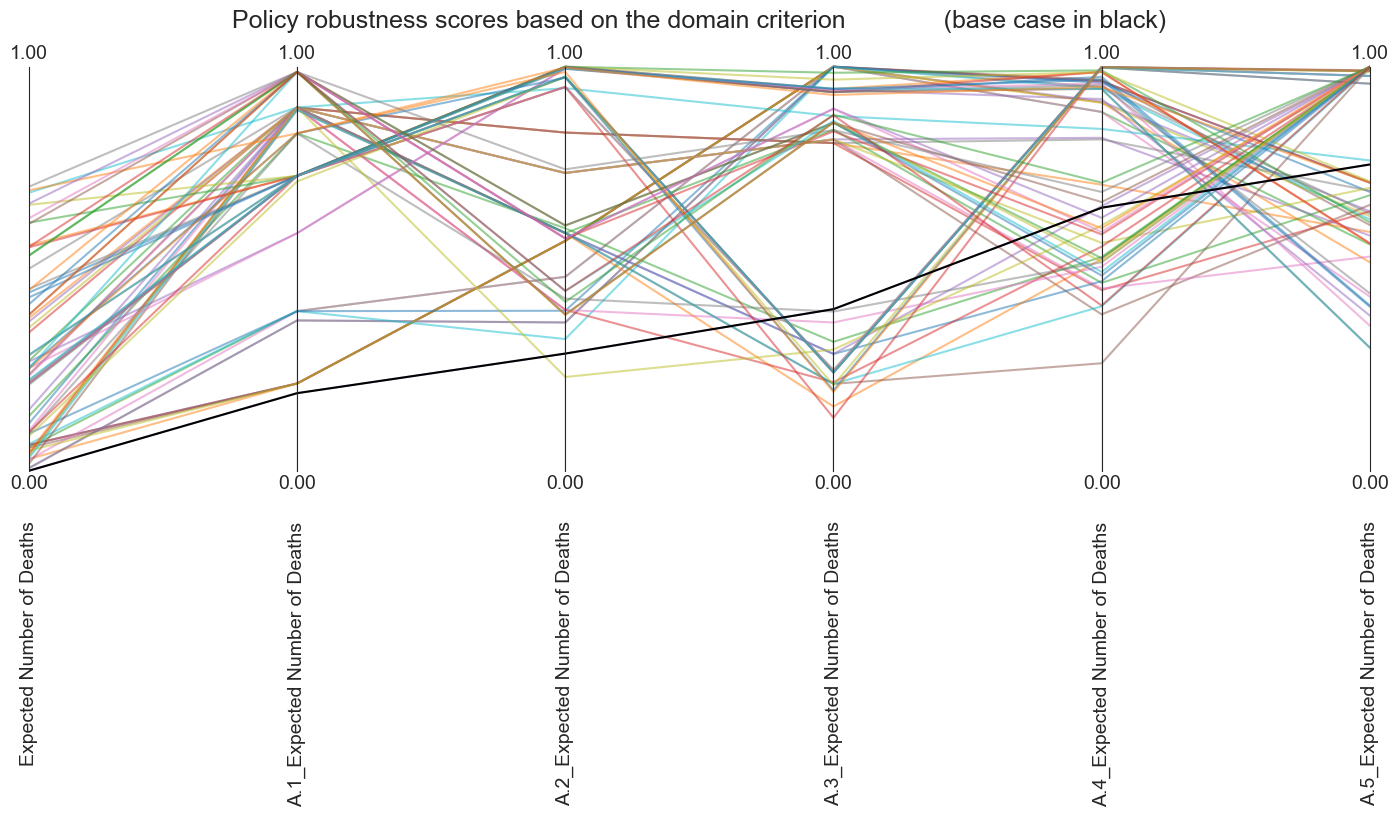

In [20]:
# Create parallel coordinate plot
limits = parcoords.get_limits(overall_scores)
limits.loc[0, :] = 0
limits.loc[1, :] = 1
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores, alpha=0.5)
paraxes.plot(overall_scores.iloc[64], alpha=1, color='black')

# Save and show plot
fig = paraxes.fig
fig.set_size_inches(15,15)
fig.suptitle("Policy robustness scores based on the domain criterion \
             (base case in black)", fontsize=18)
plt.savefig("figures/S4_parcoords_domain_criterion.png", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Highlight those policies which are most robust on the total expected number of deaths
dc_robust_totaldeaths = overall_scores[overall_scores['Expected Number of Deaths']>0.5]
dc_robust_totaldeaths

,Expected Number of Deaths,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths
19,0.688,0.899,0.947,0.878,0.846,0.768
31,0.558,0.730,1.000,0.945,0.987,0.562
32,0.614,0.730,1.000,0.985,0.991,0.615
33,0.553,0.730,1.000,0.937,0.987,0.563
38,0.658,0.730,1.000,0.968,0.987,0.716
41,0.694,0.835,0.998,0.930,0.950,0.713
52,0.533,0.987,0.607,0.861,0.526,1.000
53,0.554,0.987,0.575,0.840,0.585,1.000
54,0.661,0.987,0.575,0.896,0.626,1.000
55,0.611,0.987,0.607,0.861,0.665,1.000


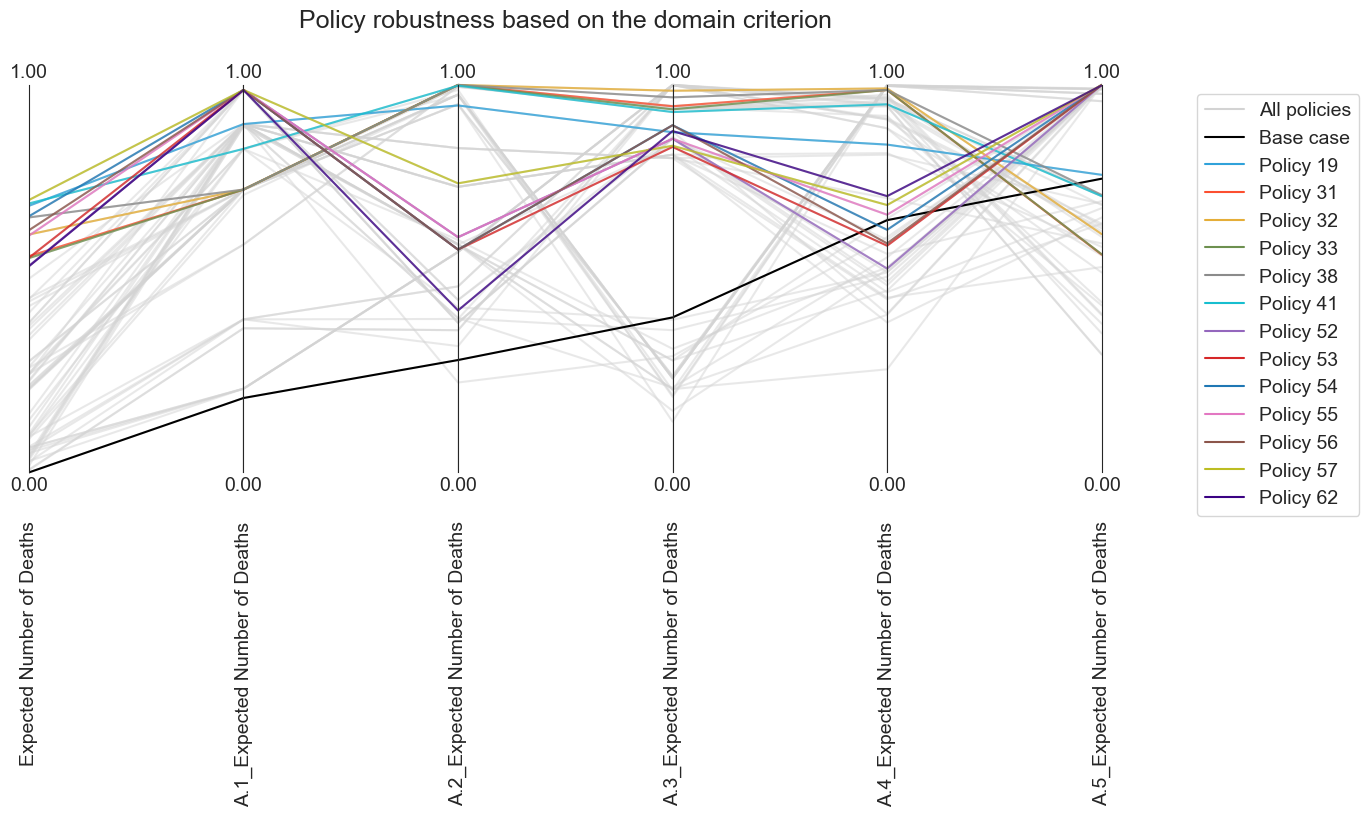

In [22]:
# Highlight those policies which are most robust on the total expected number of deaths
dc_robust_totaldeaths = overall_scores[overall_scores['Expected Number of Deaths']>0.5]
import colorcet as cc
custom_palette = sns.color_palette(cc.glasbey_hv[:15], n_colors=len(dc_robust_totaldeaths))

# Create parallel coordinate plot
limits = parcoords.get_limits(overall_scores)
limits.loc[0, :] = 0
limits.loc[1, :] = 1
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores, alpha=0.5, color='lightgrey', label = "All policies")
paraxes.plot(overall_scores.iloc[64], alpha=1, color='black', label = "Base case")
for i, (policy_nr, policy_outcomes) in enumerate(dc_robust_totaldeaths.iterrows()):
    paraxes.plot(dc_robust_totaldeaths.loc[policy_nr], alpha=0.8, color=custom_palette[i],
                 label="Policy {}".format(policy_nr))
paraxes.legend()

# Save and show plot
fig = paraxes.fig
fig.set_size_inches(12,15)
fig.suptitle("Policy robustness based on the domain criterion", fontsize=18)
plt.savefig("figures/S4_parcoords_domain_criterion_bestpolicies_numbered.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Numbers of those policies
dc_robust_totaldeaths.index.values

array([19, 31, 32, 33, 38, 41, 52, 53, 54, 55, 56, 57, 62], dtype=int64)

#### 4.5 Analysis 2: Maximum regret

In [24]:
# add scenarios and policies to the outcomes dataframe
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario   # regret is calculated by scenario
outcomes['policy'] = experiments.policy       # we want the max regret per policy

def calculate_regret(data): 
    # all outcomes should be minimized, so best performance is minimum
    zero_regrets = data.min(numeric_only=True)
    # regrets are calculated by subtracting the outcomes by the best performance
    regret = abs(np.subtract(data.loc[:, zero_regrets.index], zero_regrets))
    # add policy name to the regret
    regret['policy'] = data.policy
    # return the regret
    return regret

# calculate regret per scenario
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
# calculate the maximum regret for each policy
max_regret = regret.groupby('policy').max()

In [25]:
max_regret

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,scenario
policy,,,,,,,,,,,,,,,,,,,
0,3.965965e+09,1.714367e+08,0.367831,3.596313e+09,3.548465e+09,0.271678,9.810275e+08,8.778252e+08,0.106779,0.000000e+00,4.060905e+07,0.000000,1.228187e+08,1.157434e+08,0.008775,1.086955e+09,1.066070e+09,0.156645,0.0
1,4.032535e+09,1.448702e+08,0.294265,3.596313e+09,3.548465e+09,0.217343,9.810275e+08,8.778252e+08,0.085416,0.000000e+00,4.421502e+07,0.000000,1.752491e+08,1.655584e+08,0.008328,1.356149e+09,1.311956e+09,0.131070,0.0
2,4.002768e+09,2.025813e+08,0.367100,3.591738e+09,3.548133e+09,0.271678,9.811122e+08,8.809255e+08,0.106800,0.000000e+00,4.421502e+07,0.000000,1.947083e+08,1.850177e+08,0.010415,1.315226e+09,1.291800e+09,0.161899,0.0
3,3.965965e+09,1.750427e+08,0.367831,3.596313e+09,3.548465e+09,0.271678,9.810275e+08,8.778252e+08,0.106779,0.000000e+00,4.421502e+07,0.000000,1.228187e+08,1.157434e+08,0.008775,1.086955e+09,1.066070e+09,0.156645,0.0
4,3.970873e+09,2.076569e+08,2.448731,3.591738e+09,3.548133e+09,1.811190,9.811122e+08,8.809255e+08,0.712204,0.000000e+00,4.421502e+07,0.000000,1.357099e+08,1.286346e+08,0.068783,1.161935e+09,1.141050e+09,1.044299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1.830396e+09,2.473820e+08,0.377635,0.000000e+00,7.629909e+07,0.000000,1.165442e+09,1.120379e+09,0.097859,2.164366e+09,2.164366e+09,0.392432,2.184502e+08,2.174085e+08,0.009352,3.813995e+05,9.676792e+07,0.000063,0.0
61,1.830396e+09,2.558160e+08,0.476397,0.000000e+00,7.629909e+07,0.053647,1.165442e+09,1.120379e+09,0.122333,2.164366e+09,2.164366e+09,0.490540,1.973248e+08,1.876341e+08,0.010714,3.813995e+05,9.676792e+07,0.000079,0.0
62,1.778888e+09,3.734594e+08,0.403097,0.000000e+00,7.629909e+07,0.053647,1.057590e+09,9.972061e+08,0.119593,2.112392e+09,2.112392e+09,0.471930,1.650050e+08,1.553143e+08,0.008705,2.017984e+07,9.321218e+07,0.002748,0.0


In [26]:
# Sort based on the policy number
max_regret = max_regret.set_index(max_regret.index.astype(int)).sort_index()
max_regret = max_regret.iloc[:,:-1]
max_regret

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths
policy,,,,,,,,,,,,,,,,,,
0,3.965965e+09,1.714367e+08,0.367831,3.596313e+09,3.548465e+09,0.271678,9.810275e+08,8.778252e+08,0.106779,0.000000e+00,4.060905e+07,0.000000,1.228187e+08,1.157434e+08,0.008775,1.086955e+09,1.066070e+09,0.156645
1,4.032535e+09,1.448702e+08,0.294265,3.596313e+09,3.548465e+09,0.217343,9.810275e+08,8.778252e+08,0.085416,0.000000e+00,4.421502e+07,0.000000,1.752491e+08,1.655584e+08,0.008328,1.356149e+09,1.311956e+09,0.131070
2,4.002768e+09,2.025813e+08,0.367100,3.591738e+09,3.548133e+09,0.271678,9.811122e+08,8.809255e+08,0.106800,0.000000e+00,4.421502e+07,0.000000,1.947083e+08,1.850177e+08,0.010415,1.315226e+09,1.291800e+09,0.161899
3,3.965965e+09,1.750427e+08,0.367831,3.596313e+09,3.548465e+09,0.271678,9.810275e+08,8.778252e+08,0.106779,0.000000e+00,4.421502e+07,0.000000,1.228187e+08,1.157434e+08,0.008775,1.086955e+09,1.066070e+09,0.156645
4,3.970873e+09,2.076569e+08,2.448731,3.591738e+09,3.548133e+09,1.811190,9.811122e+08,8.809255e+08,0.712204,0.000000e+00,4.421502e+07,0.000000,1.357099e+08,1.286346e+08,0.068783,1.161935e+09,1.141050e+09,1.044299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1.830396e+09,2.473820e+08,0.377635,0.000000e+00,7.629909e+07,0.000000,1.165442e+09,1.120379e+09,0.097859,2.164366e+09,2.164366e+09,0.392432,2.184502e+08,2.174085e+08,0.009352,3.813995e+05,9.676792e+07,0.000063
61,1.830396e+09,2.558160e+08,0.476397,0.000000e+00,7.629909e+07,0.053647,1.165442e+09,1.120379e+09,0.122333,2.164366e+09,2.164366e+09,0.490540,1.973248e+08,1.876341e+08,0.010714,3.813995e+05,9.676792e+07,0.000079
62,1.778888e+09,3.734594e+08,0.403097,0.000000e+00,7.629909e+07,0.053647,1.057590e+09,9.972061e+08,0.119593,2.112392e+09,2.112392e+09,0.471930,1.650050e+08,1.553143e+08,0.008705,2.017984e+07,9.321218e+07,0.002748


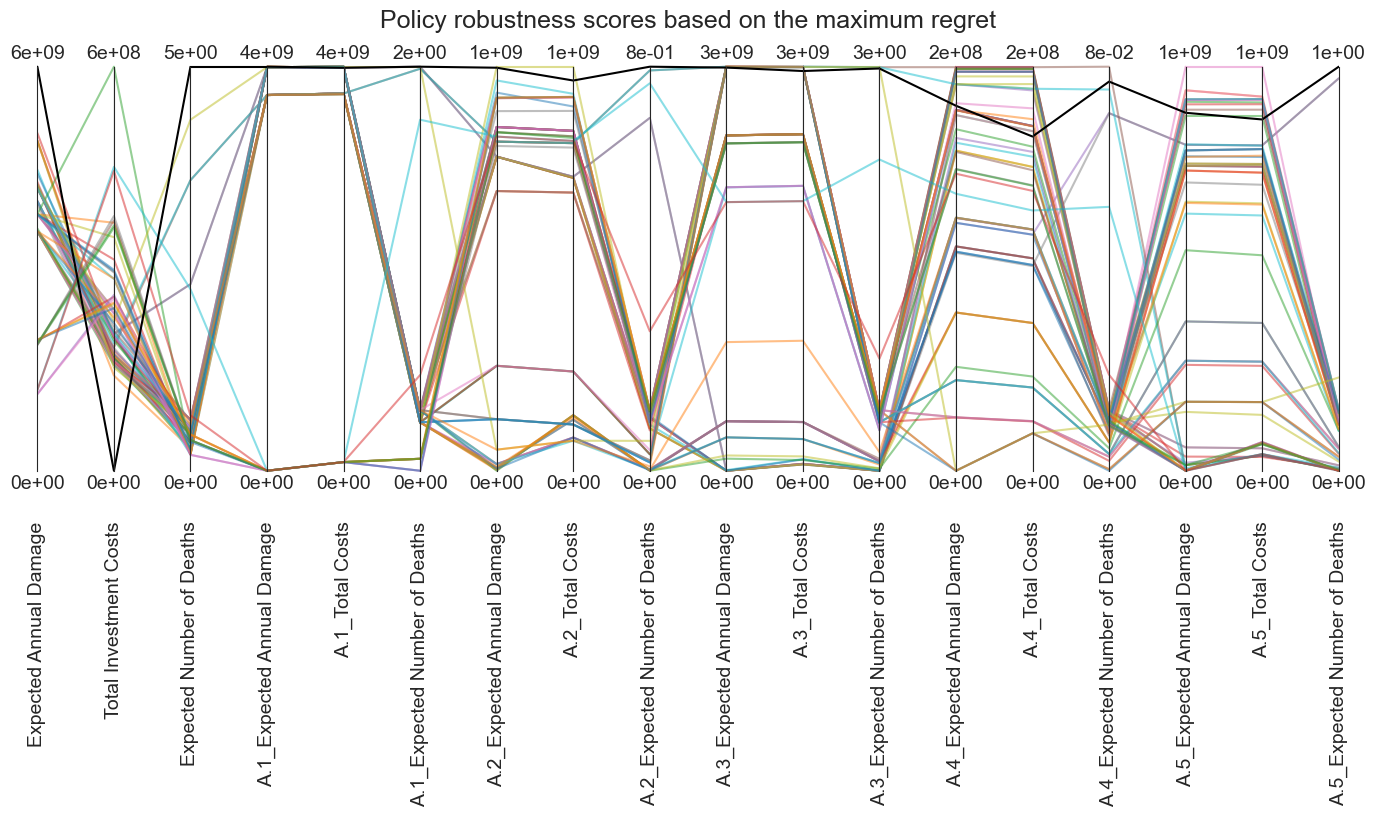

In [27]:
# Visualize the max regret using a parallel coordinate plot
limits = parcoords.get_limits(max_regret)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0
colors = sns.color_palette()

# Initiate plot
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
colors = sns.color_palette()
for i, (policy, outcomes) in enumerate(max_regret.iterrows()):
    if policy == 64:
        paraxes.plot(outcomes.to_frame().T, label='Base case', color='black')
    else:
        paraxes.plot(outcomes.to_frame().T, label='Policy {}'.format(policy), alpha=0.5) #, color=colors[i])

# show plot
fig = paraxes.fig
fig.set_size_inches(15,15)
fig.suptitle("Policy robustness scores based on the maximum regret", fontsize=18)
plt.savefig("figures/S4_parcoords_max_regret.png", dpi=300, bbox_inches='tight')
plt.show()

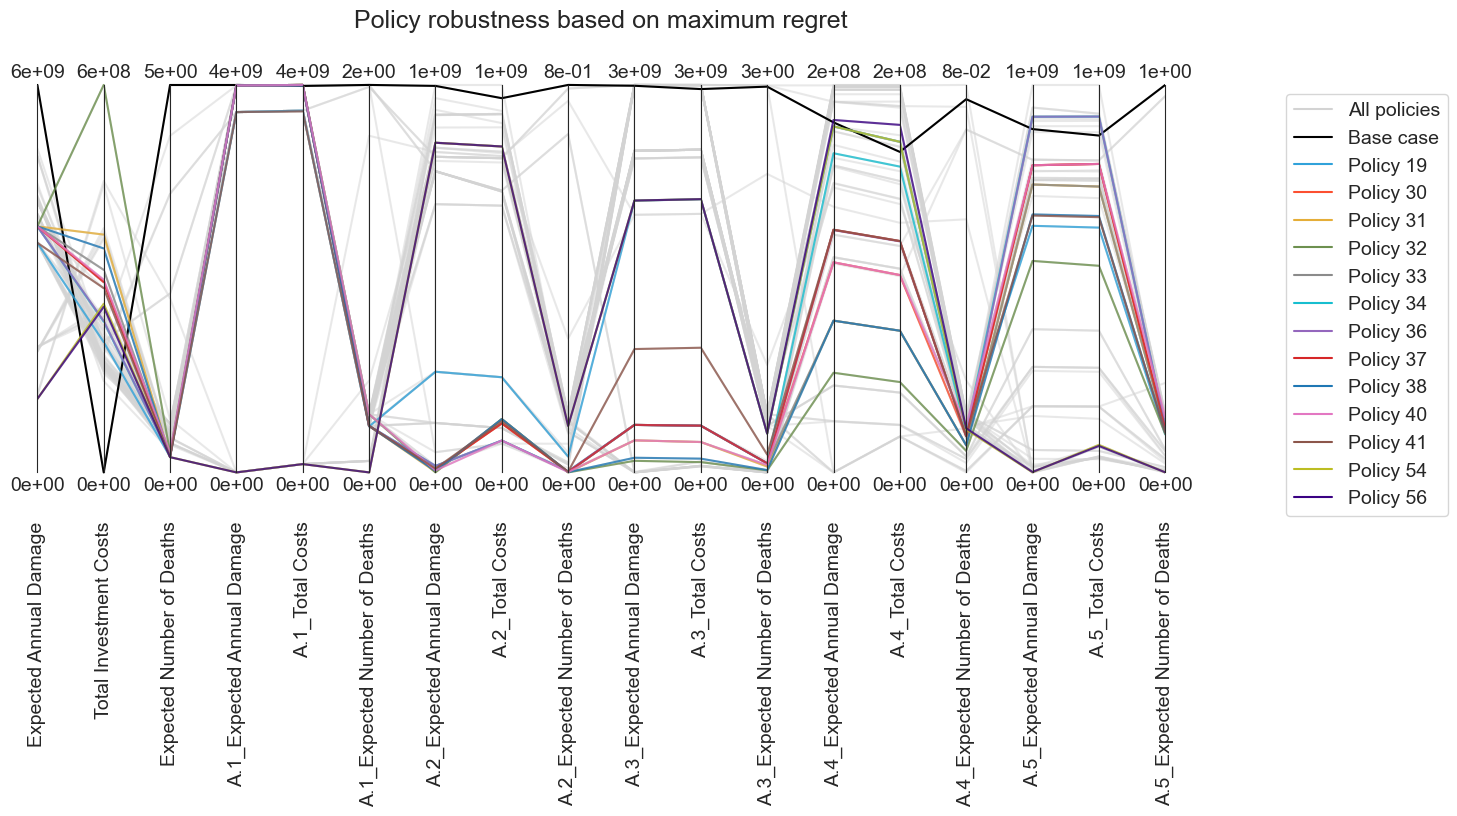

In [28]:
# Highlight those policies which are most robust on the total expected number of deaths, combined with costs and damages
mr_robust_totals = max_regret[(max_regret["Expected Annual Damage"] < max_regret["Expected Annual Damage"].mean()) &\
          (max_regret["Total Investment Costs"] < max_regret["Total Investment Costs"].mean()) &\
          (max_regret["Expected Number of Deaths"] < max_regret["Expected Number of Deaths"].mean())]

# Highlight those policies which are most robust on the total expected number of deaths (replaces the one above)
mr_robust_totals = max_regret[(max_regret["Expected Number of Deaths"] < np.percentile(max_regret["Expected Number of Deaths"], 20))]
# Define colors
custom_palette = sns.color_palette(cc.glasbey_hv, n_colors=len(mr_robust_totals))

# Create parallel coordinate plot
limits = parcoords.get_limits(max_regret)
limits.loc[0, :] = 0
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
paraxes.plot(max_regret, alpha=0.5, color='lightgrey', label = "All policies")
paraxes.plot(max_regret.iloc[64], alpha=1, color='black', label = "Base case")
for i, (policy_nr, policy_outcomes) in enumerate(mr_robust_totals.iterrows()):
    paraxes.plot(mr_robust_totals.loc[policy_nr], alpha=0.8, color=custom_palette[i],
                 label="Policy {}".format(policy_nr))
paraxes.legend()

# Save and show plot
fig = paraxes.fig
fig.set_size_inches(13,15)
fig.suptitle("Policy robustness based on maximum regret", fontsize=18)
plt.savefig("figures/S4_parcoords_max_regret_bestpolicies_numbered.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Numbers of those policies
mr_robust_totals.index.values

array([19, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 54, 56])

#### 4.6 Analyse overall robustness: heatmap of scores per policy

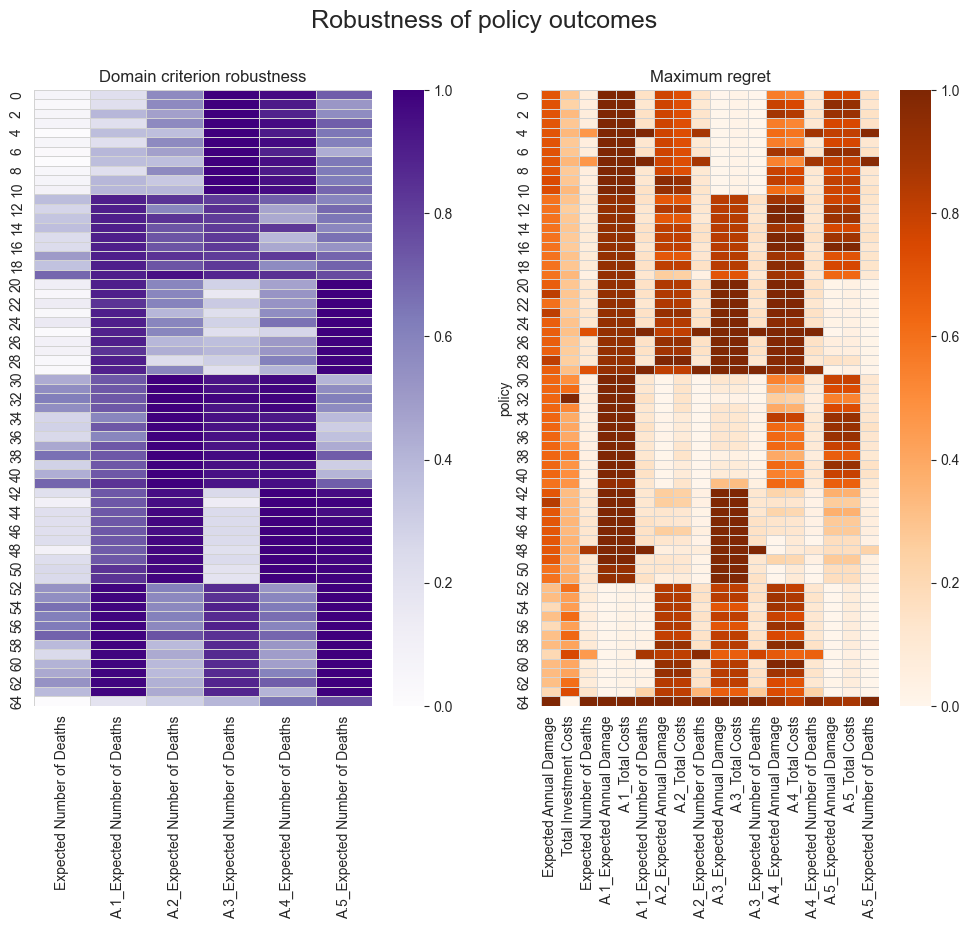

In [30]:
# Plot the levers present in the selected policies
fig, ax = plt.subplots(1,2, figsize=(12,8)) 

# Plot the policies robustness
sns.heatmap(overall_scores, cmap='Purples', ax=ax[0], linewidths=0.5, linecolor='lightgrey')
ax[0].set_title('Domain criterion robustness')

# Plot the policies maximum regret
sns.heatmap(max_regret/max_regret.max(), cmap='Oranges', ax=ax[1], linewidths=0.5, linecolor='lightgrey')
ax[1].set_title('Maximum regret')

# Save and show figure
fig.suptitle("Robustness of policy outcomes", fontsize=18)
plt.savefig("figures/S4_heatmap_policy_robustness.png", dpi=300, bbox_inches='tight')
plt.show()

#### 4.7 Identify policies which are robust on all both criteria

In [31]:
# Best policies based on max regret?
mr_robust_totals.index.values

array([19, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 54, 56])

In [32]:
# Best policies based on domain criterion?
dc_robust_totaldeaths.index.values

array([19, 31, 32, 33, 38, 41, 52, 53, 54, 55, 56, 57, 62], dtype=int64)

In [33]:
# Policies which are robust on both criteria
most_robust = list(set(mr_robust_totals.index.values) & set(dc_robust_totaldeaths.index.values))
most_robust

[32, 33, 38, 41, 19, 54, 56, 31]

#### 4.8 Select policies for scenario discovery

In [34]:
# Based on the preference of the Delta Commission, include policies with RvR as well
incl_rvr = [31, 32, 33, 38, 52, 55, 57, 62]

In [35]:
# Combine the 'most robust' with the 'rvr' policies
select = most_robust #+ incl_rvr
select

[32, 33, 38, 41, 19, 54, 56, 31]

#### 4.8 Extract and save the selected policies

In [36]:
# Reload the policies
policies_file_name = 'results/S3_candidate_policies.csv'
policies = pd.read_csv(policies_file_name, index_col=0)

In [37]:
# Extract the selected policies
selected_policies = policies.loc[select,:]
selected_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
32,0,0,0,0,0,0,1,1,1,0,...,0,6,0,0,6,0,0,2,0,0
33,0,0,0,0,0,0,1,0,0,0,...,0,7,0,0,7,0,0,4,0,0
38,0,0,0,0,0,0,1,1,0,0,...,0,7,0,0,7,0,0,5,0,0
41,0,0,0,0,0,0,0,0,0,0,...,0,8,0,0,5,0,0,5,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,3,0,0,5,0,0
54,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,0,3,0,10,3,0
56,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,0,2,0,10,2,0
31,0,0,0,0,0,0,1,1,1,0,...,0,5,0,0,7,0,0,4,0,0


In [38]:
# Save the selected policies
selection_file_name = 'results/S4_selected_policies.csv'
selected_policies.to_csv(selection_file_name)

#### 4.9 Load the selected policies

In [39]:
# For further analysis: reload the selected policies
selection_file_name = 'results/S4_selected_policies.csv'
selected_policies = pd.read_csv(selection_file_name, index_col=0)

In [40]:
# View the selected policy
selected_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
32,0,0,0,0,0,0,1,1,1,0,...,0,6,0,0,6,0,0,2,0,0
33,0,0,0,0,0,0,1,0,0,0,...,0,7,0,0,7,0,0,4,0,0
38,0,0,0,0,0,0,1,1,0,0,...,0,7,0,0,7,0,0,5,0,0
41,0,0,0,0,0,0,0,0,0,0,...,0,8,0,0,5,0,0,5,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,3,0,0,5,0,0
54,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,0,3,0,10,3,0
56,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,0,2,0,10,2,0
31,0,0,0,0,0,0,1,1,1,0,...,0,5,0,0,7,0,0,4,0,0


In [41]:
policies = selected_policies.sort_index()

In [42]:
# Define the different types of levers present in the policies
RfR_levers = ['0_RfR 0', '0_RfR 1', '0_RfR 2',
              '1_RfR 0', '1_RfR 1', '1_RfR 2',
              '2_RfR 0', '2_RfR 1', '2_RfR 2',
              '3_RfR 0', '3_RfR 1', '3_RfR 2',
              '4_RfR 0', '4_RfR 1', '4_RfR 2']
EWS_lever = ['EWS_DaysToThreat']
DikeIncrease_levers = ['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
                       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
                       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
                       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
                       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']

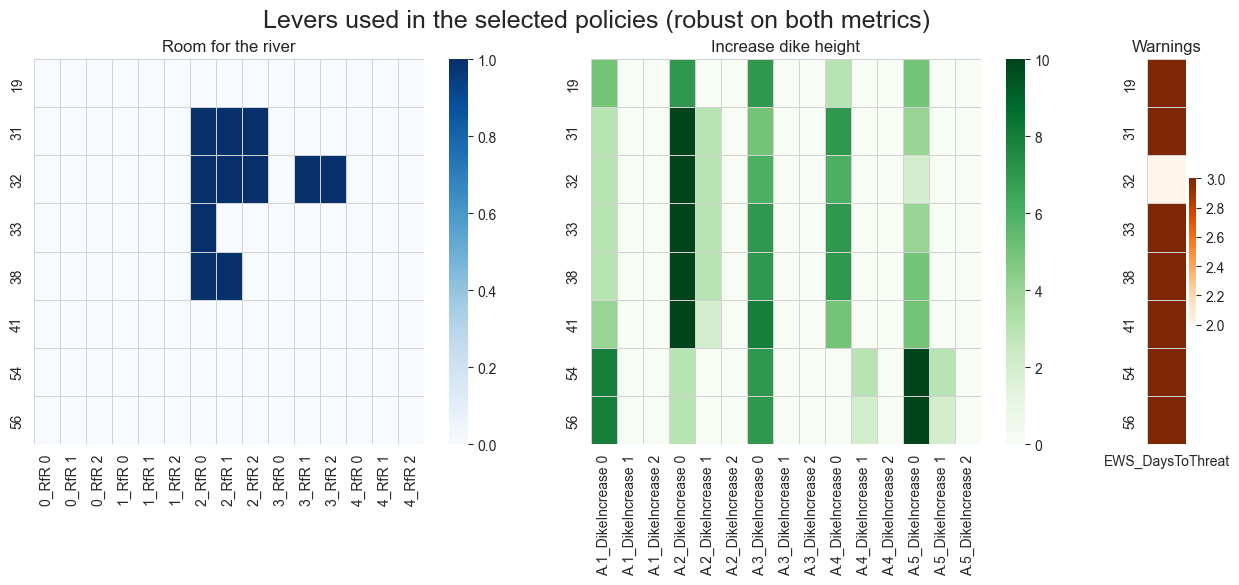

In [43]:
# Plot the levers present in the selected policies
fig, ax = plt.subplots(1,3, figsize=(15,5), width_ratios=[10, 10, 1]) #, sharex=True) 

# Plot the room for the river levers
sns.heatmap(policies.loc[:, RfR_levers], cmap='Blues', ax=ax[0], linewidths=0.5, linecolor='lightgrey')
ax[0].set_title('Room for the river')

# Plot the dike increase levers
sns.heatmap(policies.loc[:, DikeIncrease_levers], cmap='Greens', ax=ax[1], linewidths=0.5, linecolor='lightgrey')
ax[1].set_title('Increase dike height')

# Plot the room for the river levers
sns.heatmap(policies.loc[:, EWS_lever], cmap='Oranges', ax=ax[2], linewidths=0.5, linecolor='lightgrey')
ax[2].set_title('Warnings')

# Save and show figure
fig.suptitle("Levers used in the selected policies (robust on both metrics)", fontsize=18)
plt.savefig("figures/S4_heatmap_selected_policies_levers.png", dpi=300, bbox_inches='tight')
plt.show()

## Step 5. Scenario Discovery
#### *See script: G11_S5_ScenarioDiscovery.ipynb*